# Figures

In this notebook, I collect the codes that are used for making figures. This is prepared to fulfill the data availability requirements.

## Packages and functions

In [184]:
from skimage import io, draw
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imutils import rotate
from matplotlib.patches import Rectangle
from myimagelib.myImageLib import readdata, bestcolor, show_progress, to8bit
import os
from myimagelib.pivLib import PIV, PIV_masked, read_piv, to_matrix, apply_mask, compact_PIV
from IPython.display import clear_output
from myimagelib.corrLib import divide_windows, corrS
from tifffile import imwrite
from nd2reader import ND2Reader
from scipy.io import loadmat
from scipy.ndimage import uniform_filter1d, gaussian_filter1d, map_coordinates, gaussian_filter, uniform_filter
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks
plt.rcParams['ytick.major.size'] = 2  # Length of major ticks
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks

def flow_potential(phi, type="v6"):
    """Flow potential of edge flow. Double well.
    phi -- flow rate
    type -- v6 or v4, denoting two plausible models."""
    if type == "v6":
        return - 1 / 4 * phi ** 4 + 1/6 * phi**6
    elif type == "v4":
        return - 1 / 2 * phi ** 2 + 1/4 * phi**4
        
def h_diode_soft(flow, flow_preferred, gamma=1):
    """
    Order 2 diode potential. 

    H = gamma * (flow - flow_preferred) ** 2

    flow -- a multidimensional array
    flow_preferred -- a single number
    gamma -- an arbitrary coefficient
    """
    if flow_preferred == 0:
        return 0
    else:
        return gamma * (flow - flow_preferred) ** 2

def fndstruct(sigma1, sigma2, im):
    """
    Returns the structure tensor orientation of an image.

    Args:
    sigma1 -- gaussian filter sigma for the raw image.
    sigma2 -- gaussian filter sigma for the gradient fields.
    im -- the input image, [M x N].

    Returns:
    director -- the director field of the nematic system, [M x N x 2].
    """
    imgf = gaussian_filter(im, sigma1)

    gx, gy = np.gradient(imgf)

    gxgx = gx * gx
    gxgy = gx * gy
    gygy = gy * gy

    gxgx = gaussian_filter(gxgx, sigma2)
    gxgy = gaussian_filter(gxgy, sigma2)
    gygy = gaussian_filter(gygy, sigma2)

    aa = np.array([[gxgx, gxgy], [gxgy, gygy]])
    eigenvalues, eigenvectors = np.linalg.eig(aa.transpose(2, 3, 0, 1).reshape(-1, 2, 2))
    eigenvalues = eigenvalues.reshape(aa.shape[2], aa.shape[3], 2)
    eigenvectors = eigenvectors.reshape(aa.shape[2], aa.shape[3], 2, 2)

    # Find the indices of the smaller eigenvalues
    indices = np.argmax(eigenvalues, axis=2)

    # Extract the corresponding eigenvectors
    director = np.array([eigenvectors[i, j, :, indices[i, j]] for i in range(eigenvectors.shape[0]) for j in range(eigenvectors.shape[1])])
    director = director.reshape(eigenvectors.shape[0], eigenvectors.shape[1], 2)

    # require the y component director to be positive, otherwise flip the director
    director[director[:,:,1]<=0] *= -1

    return director

def compute_bending_energy(Q_tensor):
    """
    Compute the bending energy from a 2D Q-tensor.

    Args:
    Q_tensor: A 2D array of Q-tensor components with shape (Nx, Ny, 2, 2).

    Returns:
    bending_energy: The total bending energy.
    """

    Nx, Ny, _, _ = Q_tensor.shape

    # Compute spatial derivatives using finite differences
    dQxx_dx = np.gradient(Q_tensor[:, :, 0, 0], axis=0)
    dQxx_dy = np.gradient(Q_tensor[:, :, 0, 0], axis=1)
    dQxy_dx = np.gradient(Q_tensor[:, :, 0, 1], axis=0)
    dQxy_dy = np.gradient(Q_tensor[:, :, 0, 1], axis=1)
    dQyy_dx = np.gradient(Q_tensor[:, :, 1, 1], axis=0)
    dQyy_dy = np.gradient(Q_tensor[:, :, 1, 1], axis=1)

    # Compute the bending energy density
    bending_energy = (
        dQxx_dx**2 + dQxx_dy**2 +
        dQxy_dx**2 + dQxy_dy**2 +
        dQyy_dx**2 + dQyy_dy**2
    )

    return bending_energy

def qTensor(director, size=10):
    """
    Compute the Q-tensor from the director field.
    """
    Q = np.zeros((director.shape[0], director.shape[1], 2, 2))
    Q[:, :, 0, 0] = uniform_filter(director[:, :, 0] * director[:, :, 0], size=size) - 0.5
    Q[:, :, 0, 1] = uniform_filter(director[:, :, 0] * director[:, :, 1], size=size)
    Q[:, :, 1, 0] = uniform_filter(director[:, :, 1] * director[:, :, 0], size=size)
    Q[:, :, 1, 1] = uniform_filter(director[:, :, 1] * director[:, :, 1], size=size) - 0.5

    return Q

## Figure 2: straight channels, symmetric and asymmetric

### Symmetric channels

In [22]:
base = r"E:\AN\SYMMETRIC\15 dec 2022"
folder = os.path.join(base, "Flow_rate")
l = readdata(folder, "csv")
window_size = 50
list(l.Name)

['00', '01', '02', '03']

C:\Users\zl948\AppData\Local\Temp\ipykernel_116796\884673480.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  video_colors = plt.cm.get_cmap("winter", len(files))


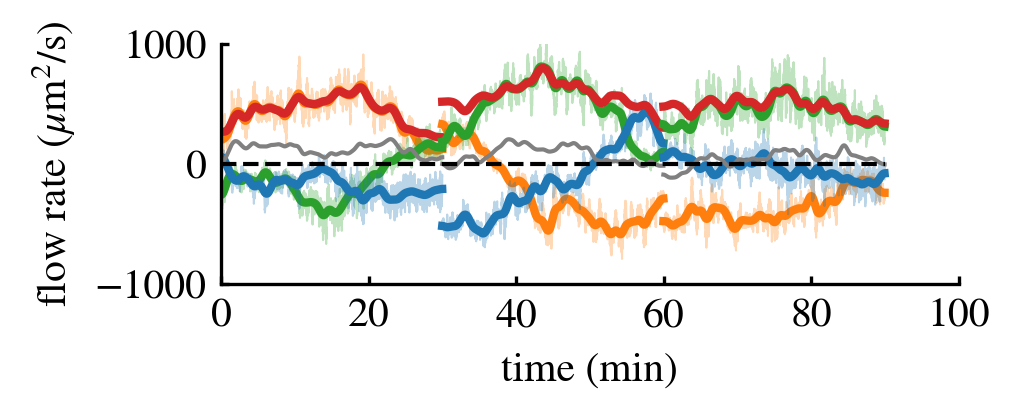

In [7]:
files = ["{:02d}.csv".format(i) for i in range(0,3)]

colors = {"A": bestcolor(0), "B": bestcolor(1), "C": bestcolor(2), "normalizer": bestcolor(3)}
video_colors = plt.cm.get_cmap("winter", len(files))

plt.figure(figsize=(3.5, 1.5), dpi=300)
offset = 0
for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file)).dropna()
    flowrate["normalizer"] = gaussian_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), sigma=window_size, axis=0)
    flowrate_smooth = gaussian_filter1d(flowrate[["A", "B", "C"]], sigma=50, axis=0)
    flowrate.t /= 60
    # flowrate = replace_outlier(flowrate)
    if num == 0:        
        for i, channel_name in enumerate(flowrate.drop(columns=["t"])):        
            plt.plot(flowrate.t + offset, flowrate[channel_name], color=colors[channel_name], alpha=0.3, lw=0.5)
            plt.plot(flowrate.t + offset, gaussian_filter1d(flowrate[channel_name], sigma=50), color=colors[channel_name], lw=2, label=channel_name)
        plt.plot(flowrate.t + offset, flowrate_smooth.sum(axis=1), color="gray", label="A+B+C", lw=1)
    else:
        for i, channel_name in enumerate(flowrate.drop(columns=["t"])):  
            plt.plot(flowrate.t + offset, flowrate[channel_name], color=colors[channel_name], alpha=0.3, lw=0.5)
            plt.plot(flowrate.t + offset, gaussian_filter1d(flowrate[channel_name], sigma=50), color=colors[channel_name], lw=2)
        plt.plot(flowrate.t + offset, flowrate_smooth.sum(axis=1), color="gray", lw=1)
    
    # video indicator
    offset0 = offset
    offset += flowrate["t"].max()
#     y = flowrate.drop(columns=["t"]).min().min()
#     plt.plot([offset0, offset], [y, y], color=video_colors(num))
#     plt.annotate("{}".format(os.path.splitext(file)[0]), ((offset0+offset)/2, y), xycoords="data", 
#                 horizontalalignment="center", verticalalignment="top")
# # plt.grid(True, ls="--")
plt.plot([0, offset], [0, 0], ls="--", lw=1, color="black")
# plt.legend(ncol=3, frameon=False, fontsize=8)
plt.xlabel("time (min)")
plt.ylabel("flow rate ($\mu$m$^2$/s)")
plt.yticks([-1000, 0, 1000])
plt.ylim([-1000, 1000])
plt.xlim([0, 100])
# upper axis line off
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(r"symmetric.pdf")

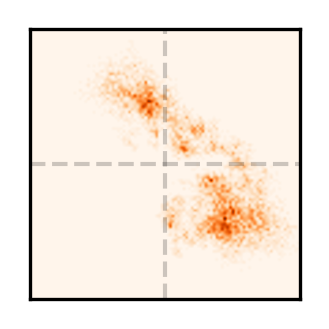

In [8]:
fr_list = []

for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file)).dropna()
    flowrate["normalizer"] = gaussian_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), sigma=window_size, axis=0)
    fr_list.append(flowrate)
combined = pd.concat(fr_list)

fig, ax = plt.subplots(figsize=(1.2, 1.2), dpi=300)
lim = 1000

H, xedges, yedges = np.histogram2d(combined["B"], combined["C"], bins=(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100)))
ax.imshow(H, interpolation='spline16', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax.plot([-lim, lim], [0, 0], ls="--", lw=1, color="black", alpha=0.2)
ax.plot([0, 0], [-lim, lim], ls="--", lw=1, color="black", alpha=0.2)
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
# ax.set_xlabel("C")
# ax.set_ylabel("B")
# hide ticks
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig("symmetric_histogram.pdf")

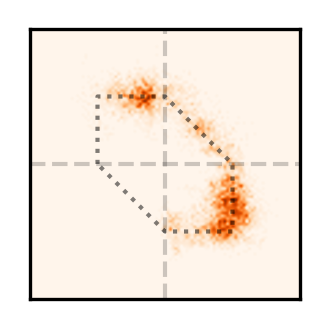

In [9]:
fr_list = []

for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file)).dropna()
    flowrate["normalizer"] = gaussian_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), sigma=window_size, axis=0)
    fr_list.append(flowrate)
combined = pd.concat(fr_list)

fig, ax = plt.subplots(figsize=(1.2, 1.2), dpi=300)
lim = 2

H, xedges, yedges = np.histogram2d(combined["B"]/combined["normalizer"], combined["C"]/combined["normalizer"], bins=(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100)))
ax.imshow(H, interpolation='spline16', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax.plot([-lim, lim], [0, 0], ls="--", lw=1, color="black", alpha=0.2)
ax.plot([0, 0], [-lim, lim], ls="--", lw=1, color="black", alpha=0.2)
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
# ax.set_xlabel("C")
# ax.set_ylabel("B")
# hide ticks
ax.set_xticks([])
ax.set_yticks([])
# draw mass conservation line
x = [-1, -1, 0, 1, 1, 0, -1]
y = [0, 1, 1, 0, -1, -1, 0]
plt.plot(x, y, lw=1, color="black", alpha=0.5, ls=":")
plt.tight_layout()
plt.savefig("symmetric_histogram_normalized.pdf")

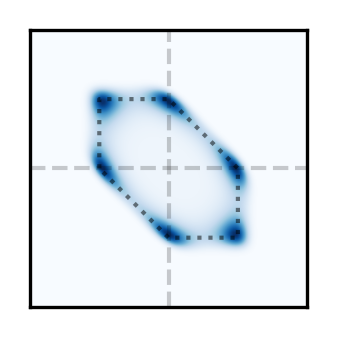

In [11]:
lim = 2
num_points = 100
phi1 = np.linspace(-lim, lim, num_points)
phi2 = np.linspace(-lim, lim, num_points)
# phi3 = np.linspace(-lim, lim)
D = np.array([-1, -1, -1])
a = 30# lambda
b = 2 # mu
H = np.zeros((len(phi1), len(phi2)))

fig, ax = plt.subplots(figsize=(1.2, 1.2), dpi=300)
for i, p1 in enumerate(phi1):
    for j, p2 in enumerate(phi2):
        p3 = - p1 - p2
        H[i, j] = a * (flow_potential(p1, type="v6") + flow_potential(p2, type="v6") + flow_potential(p3, type="v6")) + 1/2 * b * np.sum((D * np.array([p1, p2, p3]))**2) 
ax.imshow(np.exp(-H), origin="lower", extent=(-lim, lim, -lim, lim), cmap="Blues", interpolation="spline16")
ax.plot([-lim, lim], [0, 0], ls="--", lw=1, color="black", alpha=0.2)
ax.plot([0, 0], [-lim, lim], ls="--", lw=1, color="black", alpha=0.2)
ax.set_xticks([-1, 1])
ax.set_yticks([-1, 1])
ax.set_xticks([-2, 0, 2])
ax.set_yticks([-2, 0, 2])
# ax.set_xlabel("$\phi_2$")
# ax.set_ylabel("$\phi_1$")
ax.set_xticks([])
ax.set_yticks([])
# draw mass conservation line
x = [-1, -1, 0, 1, 1, 0, -1]
y = [0, 1, 1, 0, -1, -1, 0]
plt.plot(x, y, lw=1, color="black", alpha=0.5, ls=":")
fig.savefig("theo_prob_01.pdf")

### Asymmetric channels

In [30]:
main_folder = "E:\AN\ASYMMETRIC"
dates = ["03 mar 2023"]
window_size = 50
l_list = []
for date in dates:
    folder = os.path.join(main_folder, date, "Flow_rate")
    l_list.append(readdata(folder, "csv"))
l = pd.concat(l_list)
list(l.Name)

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11']

In [ ]:
# some statistics
window_size = 50
for date in dates:
    folder = os.path.join(main_folder, date, "Flow_rate")
    l = readdata(folder, "csv")
    total = 0
    fr_list = []
    for num, i in l.iterrows():
        flowrate = pd.read_csv(i.Dir).dropna()
        flowrate["normalizer"] = uniform_filter1d(flowrate[flowrate.columns.drop("t")].abs().max(axis=1), size=window_size, axis=0)
        total += len(flowrate)
        fr_list.append(flowrate)
    combined = pd.concat(fr_list)
    nominal_flowrate = combined["normalizer"].mean()
    print("{0:18}: {1:2d} videos, {2:5d} points, {3:7.2f} um^2/s".format(date, num+1, total, nominal_flowrate))

C:\Users\zl948\AppData\Local\Temp\ipykernel_23960\1198955256.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  video_colors = plt.cm.get_cmap("winter", len(files))


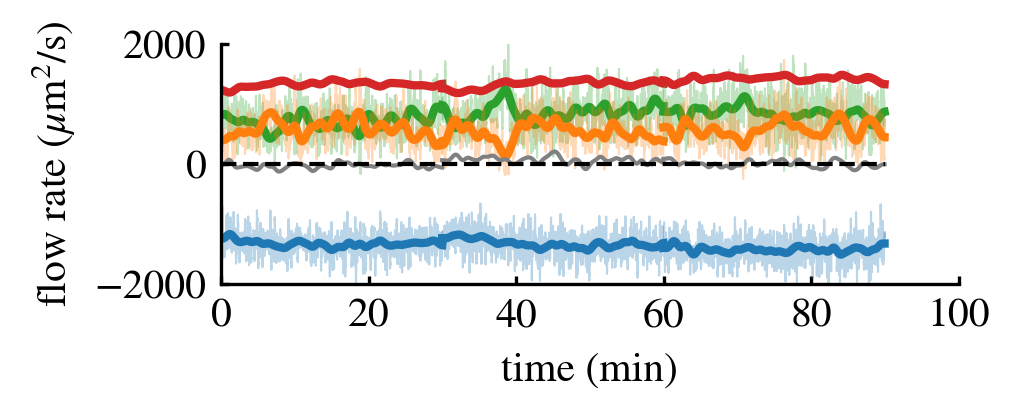

In [27]:
files = [f"{i:02d}.csv" for i in range(2, 6)]

colors = {"A": bestcolor(0), "B": bestcolor(1), "C": bestcolor(2), "normalizer": bestcolor(3)}
video_colors = plt.cm.get_cmap("winter", len(files))

plt.figure(figsize=(3.5, 1.5), dpi=300)
offset = 0
for num, f in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, f)).dropna()
    flowrate.t /= 60
    flowrate.t += offset
    flowrate = flowrate.loc[flowrate.t <= 90]
    flowrate["normalizer"] = gaussian_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), sigma=window_size, axis=0)
    flowrate_smooth = gaussian_filter1d(flowrate[["A", "B", "C"]], sigma=50, axis=0)
    
    # flowrate = replace_outlier(flowrate)
    if num == 0:        
        for i, channel_name in enumerate(flowrate.drop(columns=["t"])):        
            plt.plot(flowrate.t, flowrate[channel_name], color=colors[channel_name], alpha=0.3, lw=0.5)
            plt.plot(flowrate.t, gaussian_filter1d(flowrate[channel_name], sigma=50), color=colors[channel_name], lw=2, label=channel_name)
        plt.plot(flowrate.t, flowrate_smooth.sum(axis=1), color="gray", label="A+B+C", lw=1)
    else:
        for i, channel_name in enumerate(flowrate.drop(columns=["t"])):  
            plt.plot(flowrate.t, flowrate[channel_name], color=colors[channel_name], alpha=0.3, lw=0.5)
            plt.plot(flowrate.t, gaussian_filter1d(flowrate[channel_name], sigma=50), color=colors[channel_name], lw=2)
        plt.plot(flowrate.t, flowrate_smooth.sum(axis=1), color="gray", lw=1)
    
    # video indicator
    offset0 = offset
    offset = flowrate["t"].max()

plt.plot([0, offset], [0, 0], ls="--", lw=1, color="black")
# plt.legend(ncol=3, frameon=False, fontsize=8)
plt.xlabel("time (min)")
plt.ylabel("flow rate ($\mu$m$^2$/s)")
plt.yticks([-2000, 0, 2000])
plt.ylim([-2000, 2000])
plt.xlim([0, 100])
# upper axis line off
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(r"length.svg")

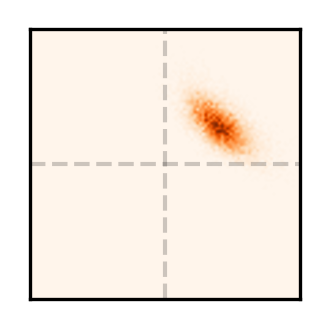

In [25]:
fr_list = []

for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file)).dropna()
    flowrate["normalizer"] = gaussian_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), sigma=window_size, axis=0)
    fr_list.append(flowrate)
combined = pd.concat(fr_list)

fig, ax = plt.subplots(figsize=(1.2, 1.2), dpi=300)
lim = 2000

H, xedges, yedges = np.histogram2d(combined["B"], combined["C"], bins=(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100)))
ax.imshow(H, interpolation='spline16', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax.plot([-lim, lim], [0, 0], ls="--", lw=1, color="black", alpha=0.2)
ax.plot([0, 0], [-lim, lim], ls="--", lw=1, color="black", alpha=0.2)
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
# ax.set_xlabel("C")
# ax.set_ylabel("B")
# hide ticks
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig("symmetric_histogram.svg")

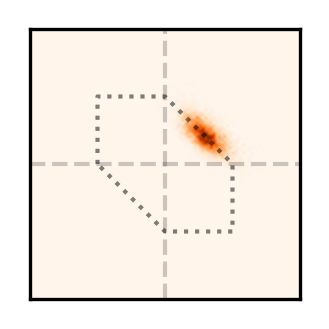

In [26]:
fr_list = []

for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file)).dropna()
    flowrate["normalizer"] = gaussian_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), sigma=window_size, axis=0)
    fr_list.append(flowrate)
combined = pd.concat(fr_list)

fig, ax = plt.subplots(figsize=(1.2, 1.2), dpi=300)
lim = 2

H, xedges, yedges = np.histogram2d(combined["B"]/combined["normalizer"], combined["C"]/combined["normalizer"], bins=(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100)))
ax.imshow(H, interpolation='spline16', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax.plot([-lim, lim], [0, 0], ls="--", lw=1, color="black", alpha=0.2)
ax.plot([0, 0], [-lim, lim], ls="--", lw=1, color="black", alpha=0.2)
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
# ax.set_xlabel("C")
# ax.set_ylabel("B")
# hide ticks
ax.set_xticks([])
ax.set_yticks([])
# draw mass conservation line
x = [-1, -1, 0, 1, 1, 0, -1]
y = [0, 1, 1, 0, -1, -1, 0]
plt.plot(x, y, lw=1, color="black", alpha=0.5, ls=":")
plt.tight_layout()
plt.savefig("symmetric_histogram_normalized.svg")

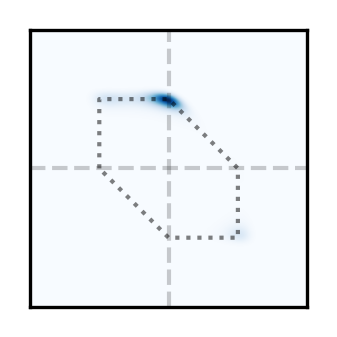

In [28]:
lim = 2
num_points = 100
phi1 = np.linspace(-lim, lim, num_points)
phi2 = np.linspace(-lim, lim, num_points)
# phi3 = np.linspace(-lim, lim)
D = np.array([-1, -1, -1])
a = 30# lambda
b = 2 # mu
H = np.zeros((len(phi1), len(phi2)))

fig, ax = plt.subplots(figsize=(1.2, 1.2), dpi=300)
for i, p1 in enumerate(phi1):
    for j, p2 in enumerate(phi2):
        p3 = - p1 - p2
        H[i, j] = a * (3*flow_potential(p1, type="v6") + flow_potential(p2, type="v6") + flow_potential(p3, type="v6")) + 1/2 * b * np.sum((D * np.array([p1, p2, p3]))**2) + 1/2 * b * np.sum((p3+1)**2) + h_diode_soft(p3, -1)
ax.imshow(np.exp(-H), origin="lower", extent=(-lim, lim, -lim, lim), cmap="Blues", interpolation="spline16")
ax.plot([-lim, lim], [0, 0], ls="--", lw=1, color="black", alpha=0.2)
ax.plot([0, 0], [-lim, lim], ls="--", lw=1, color="black", alpha=0.2)
ax.set_xticks([-1, 1])
ax.set_yticks([-1, 1])
ax.set_xticks([-2, 0, 2])
ax.set_yticks([-2, 0, 2])
# ax.set_xlabel("$\phi_2$")
# ax.set_ylabel("$\phi_1$")
ax.set_xticks([])
ax.set_yticks([])
# draw mass conservation line
x = [-1, -1, 0, 1, 1, 0, -1]
y = [0, 1, 1, 0, -1, -1, 0]
plt.plot(x, y, lw=1, color="black", alpha=0.5, ls=":")
fig.savefig("theo_prob_04.svg")

## Figure 3: ratchet and wall defect dynamics

In [31]:
main_folder = "E:\AN\ASYMMETRIC"
dates = ["08 jun 2023"]
window_size = 50
l_list = []
for date in dates:
    folder = os.path.join(main_folder, date, "Flow_rate")
    l_list.append(readdata(folder, "csv"))
l = pd.concat(l_list)
list(l.Name)

['06', '07', '08', '09', '10', '11', '12']

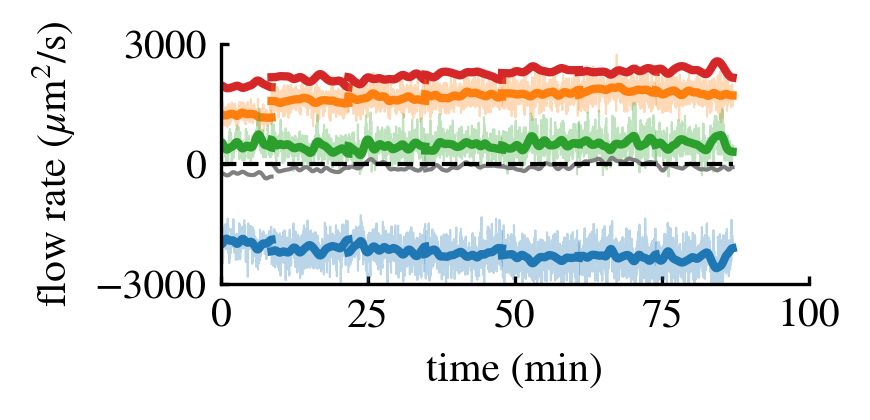

In [44]:
files = [f"{i:02d}.csv" for i in range(6, 13)]

colors = {"A": bestcolor(0), "B": bestcolor(1), "C": bestcolor(2), "normalizer": bestcolor(3)}

plt.figure(figsize=(3, 1.5), dpi=300)
offset = 0
for num, f in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, f)).dropna()
    flowrate.t /= 60
    flowrate.t += offset
    flowrate = flowrate.loc[flowrate.t <= 90]
    flowrate["normalizer"] = gaussian_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), sigma=window_size, axis=0)
    flowrate_smooth = gaussian_filter1d(flowrate[["A", "B", "C"]], sigma=50, axis=0)
    
    # flowrate = replace_outlier(flowrate)
    if num == 0:        
        for i, channel_name in enumerate(flowrate.drop(columns=["t"])):        
            plt.plot(flowrate.t, flowrate[channel_name], color=colors[channel_name], alpha=0.3, lw=0.5)
            plt.plot(flowrate.t, gaussian_filter1d(flowrate[channel_name], sigma=50), color=colors[channel_name], lw=2, label=channel_name)
        plt.plot(flowrate.t, flowrate_smooth.sum(axis=1), color="gray", label="A+B+C", lw=1)
    else:
        for i, channel_name in enumerate(flowrate.drop(columns=["t"])):  
            plt.plot(flowrate.t, flowrate[channel_name], color=colors[channel_name], alpha=0.3, lw=0.5)
            plt.plot(flowrate.t, gaussian_filter1d(flowrate[channel_name], sigma=50), color=colors[channel_name], lw=2)
        plt.plot(flowrate.t, flowrate_smooth.sum(axis=1), color="gray", lw=1)
    
    # video indicator
    offset0 = offset
    offset = flowrate["t"].max()

plt.plot([0, offset], [0, 0], ls="--", lw=1, color="black")
# plt.legend(ncol=3, frameon=False, fontsize=8)
plt.xlabel("time (min)")
plt.ylabel("flow rate ($\mu$m$^2$/s)")
plt.yticks([-3000, 0, 3000])
plt.ylim([-3000, 3000])
plt.xlim([0, 100])
# upper axis line off
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(r"ratchet.svg")

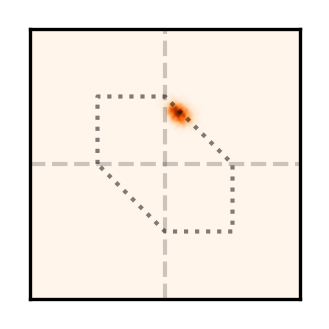

In [46]:
fr_list = []

for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file)).dropna()
    flowrate["normalizer"] = gaussian_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), sigma=window_size, axis=0)
    fr_list.append(flowrate)
combined = pd.concat(fr_list)

fig, ax = plt.subplots(figsize=(1.2, 1.2), dpi=300)
lim = 2

H, xedges, yedges = np.histogram2d(combined["B"]/combined["normalizer"], combined["C"]/combined["normalizer"], bins=(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100)))
ax.imshow(H, interpolation='spline16', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax.plot([-lim, lim], [0, 0], ls="--", lw=1, color="black", alpha=0.2)
ax.plot([0, 0], [-lim, lim], ls="--", lw=1, color="black", alpha=0.2)
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
# ax.set_xlabel("C")
# ax.set_ylabel("B")
# hide ticks
ax.set_xticks([])
ax.set_yticks([])
# draw mass conservation line
x = [-1, -1, 0, 1, 1, 0, -1]
y = [0, 1, 1, 0, -1, -1, 0]
plt.plot(x, y, lw=1, color="black", alpha=0.5, ls=":")
plt.tight_layout()
plt.savefig("ratchet1_histogram_normalized.svg")

In [47]:
main_folder = "E:\AN\ASYMMETRIC"
dates = ["02 mar 2023"]
window_size = 50
l_list = []
for date in dates:
    folder = os.path.join(main_folder, date, "Flow_rate")
    l_list.append(readdata(folder, "csv"))
l = pd.concat(l_list)
list(l.Name)

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

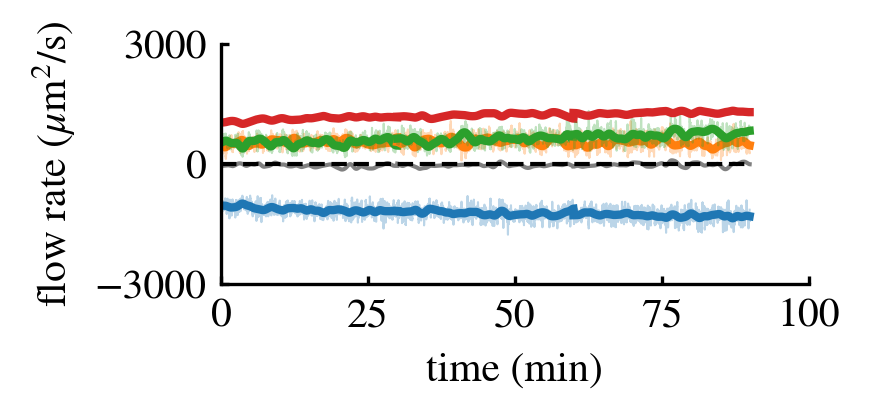

In [51]:
files = [f"{i:02d}.csv" for i in range(3)]

colors = {"A": bestcolor(0), "B": bestcolor(1), "C": bestcolor(2), "normalizer": bestcolor(3)}

plt.figure(figsize=(3, 1.5), dpi=300)
offset = 0
for num, f in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, f)).dropna()
    flowrate.t /= 60
    flowrate.t += offset
    flowrate = flowrate.loc[flowrate.t <= 90]
    flowrate["normalizer"] = gaussian_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), sigma=window_size, axis=0)
    flowrate_smooth = gaussian_filter1d(flowrate[["A", "B", "C"]], sigma=50, axis=0)
    
    # flowrate = replace_outlier(flowrate)
    if num == 0:        
        for i, channel_name in enumerate(flowrate.drop(columns=["t"])):        
            plt.plot(flowrate.t, flowrate[channel_name], color=colors[channel_name], alpha=0.3, lw=0.5)
            plt.plot(flowrate.t, gaussian_filter1d(flowrate[channel_name], sigma=50), color=colors[channel_name], lw=2, label=channel_name)
        plt.plot(flowrate.t, flowrate_smooth.sum(axis=1), color="gray", label="A+B+C", lw=1)
    else:
        for i, channel_name in enumerate(flowrate.drop(columns=["t"])):  
            plt.plot(flowrate.t, flowrate[channel_name], color=colors[channel_name], alpha=0.3, lw=0.5)
            plt.plot(flowrate.t, gaussian_filter1d(flowrate[channel_name], sigma=50), color=colors[channel_name], lw=2)
        plt.plot(flowrate.t, flowrate_smooth.sum(axis=1), color="gray", lw=1)
    
    # video indicator
    offset0 = offset
    offset = flowrate["t"].max()

plt.plot([0, offset], [0, 0], ls="--", lw=1, color="black")
# plt.legend(ncol=3, frameon=False, fontsize=8)
plt.xlabel("time (min)")
plt.ylabel("flow rate ($\mu$m$^2$/s)")
plt.yticks([-3000, 0, 3000])
plt.ylim([-3000, 3000])
plt.xlim([0, 100])
# upper axis line off
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(r"ratchet1.svg")

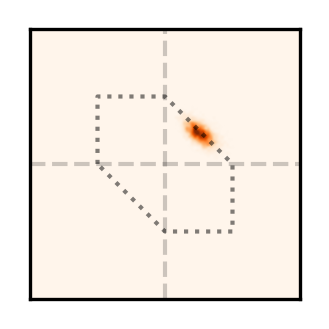

In [52]:
fr_list = []

for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file)).dropna()
    flowrate["normalizer"] = gaussian_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), sigma=window_size, axis=0)
    fr_list.append(flowrate)
combined = pd.concat(fr_list)

fig, ax = plt.subplots(figsize=(1.2, 1.2), dpi=300)
lim = 2

H, xedges, yedges = np.histogram2d(combined["B"]/combined["normalizer"], combined["C"]/combined["normalizer"], bins=(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100)))
ax.imshow(H, interpolation='spline16', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax.plot([-lim, lim], [0, 0], ls="--", lw=1, color="black", alpha=0.2)
ax.plot([0, 0], [-lim, lim], ls="--", lw=1, color="black", alpha=0.2)
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
# ax.set_xlabel("C")
# ax.set_ylabel("B")
# hide ticks
ax.set_xticks([])
ax.set_yticks([])
# draw mass conservation line
x = [-1, -1, 0, 1, 1, 0, -1]
y = [0, 1, 1, 0, -1, -1, 0]
plt.plot(x, y, lw=1, color="black", alpha=0.5, ls=":")
plt.tight_layout()
plt.savefig("ratchet1_histogram_normalized.svg")

In [53]:
main_folder = "E:\AN\SYMMETRIC"
dates = ["08 jun 2023"]
window_size = 50
l_list = []
for date in dates:
    folder = os.path.join(main_folder, date, "Flow_rate")
    l_list.append(readdata(folder, "csv"))
l = pd.concat(l_list)
list(l.Name)

['00', '02', '03', '04', '05']

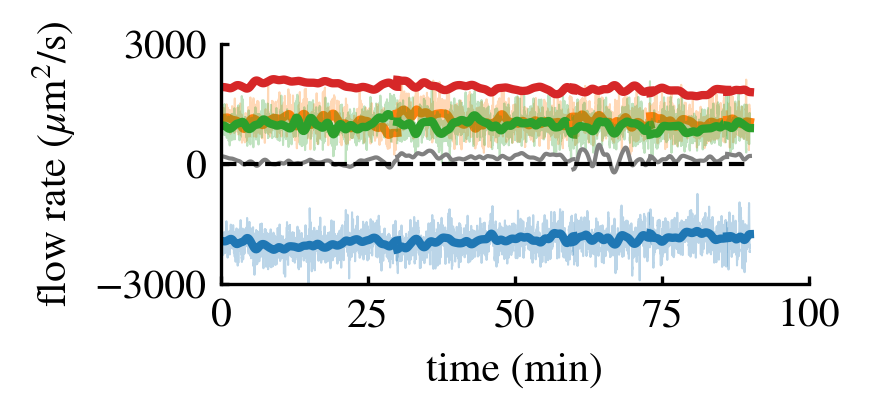

In [56]:
files = [f"{i:02d}.csv" for i in [0,2,3,4,5]]

colors = {"A": bestcolor(0), "B": bestcolor(1), "C": bestcolor(2), "normalizer": bestcolor(3)}

plt.figure(figsize=(3, 1.5), dpi=300)
offset = 0
for num, f in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, f)).dropna()
    flowrate.t /= 60
    flowrate.t += offset
    flowrate = flowrate.loc[flowrate.t <= 90]
    flowrate["normalizer"] = gaussian_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), sigma=window_size, axis=0)
    flowrate_smooth = gaussian_filter1d(flowrate[["A", "B", "C"]], sigma=50, axis=0)
    
    # flowrate = replace_outlier(flowrate)
    if num == 0:        
        for i, channel_name in enumerate(flowrate.drop(columns=["t"])):        
            plt.plot(flowrate.t, flowrate[channel_name], color=colors[channel_name], alpha=0.3, lw=0.5)
            plt.plot(flowrate.t, gaussian_filter1d(flowrate[channel_name], sigma=50), color=colors[channel_name], lw=2, label=channel_name)
        plt.plot(flowrate.t, flowrate_smooth.sum(axis=1), color="gray", label="A+B+C", lw=1)
    else:
        for i, channel_name in enumerate(flowrate.drop(columns=["t"])):  
            plt.plot(flowrate.t, flowrate[channel_name], color=colors[channel_name], alpha=0.3, lw=0.5)
            plt.plot(flowrate.t, gaussian_filter1d(flowrate[channel_name], sigma=50), color=colors[channel_name], lw=2)
        plt.plot(flowrate.t, flowrate_smooth.sum(axis=1), color="gray", lw=1)
    
    # video indicator
    offset0 = offset
    offset = flowrate["t"].max()

plt.plot([0, offset], [0, 0], ls="--", lw=1, color="black")
# plt.legend(ncol=3, frameon=False, fontsize=8)
plt.xlabel("time (min)")
plt.ylabel("flow rate ($\mu$m$^2$/s)")
plt.yticks([-3000, 0, 3000])
plt.ylim([-3000, 3000])
plt.xlim([0, 100])
# upper axis line off
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("ratchet2.svg")

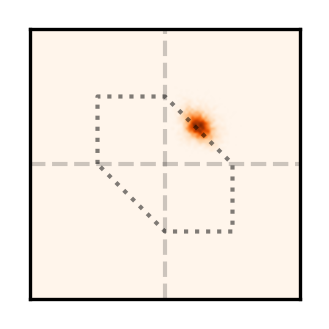

In [58]:
fr_list = []

for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file)).dropna()
    flowrate["normalizer"] = gaussian_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), sigma=window_size, axis=0)
    fr_list.append(flowrate)
combined = pd.concat(fr_list)

fig, ax = plt.subplots(figsize=(1.2, 1.2), dpi=300)
lim = 2

H, xedges, yedges = np.histogram2d(combined["B"]/combined["normalizer"], combined["C"]/combined["normalizer"], bins=(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100)))
ax.imshow(H, interpolation='spline16', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax.plot([-lim, lim], [0, 0], ls="--", lw=1, color="black", alpha=0.2)
ax.plot([0, 0], [-lim, lim], ls="--", lw=1, color="black", alpha=0.2)
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
# ax.set_xlabel("C")
# ax.set_ylabel("B")
# hide ticks
ax.set_xticks([])
ax.set_yticks([])
# draw mass conservation line
x = [-1, -1, 0, 1, 1, 0, -1]
y = [0, 1, 1, 0, -1, -1, 0]
plt.plot(x, y, lw=1, color="black", alpha=0.5, ls=":")
plt.tight_layout()
plt.savefig("ratchet2_histogram_normalized.svg")

## Figure 4: bending energy and splitting ratio

### Symmetric channels

#### Bending energy and flow rate

In [169]:
# symmetric channels
folder = r"G:\My Drive\NASync\Sample 1\nd2"
fps = 2
be = {"A": [], "B": [], "C": []}
offset = {"A": 0, "B": 0, "C": 0}
file_range = range(6, 12)
for i in file_range:
    for channel in ["A", "B", "C"]:
        e = pd.read_csv(os.path.join(folder, "bending_energy", f"{i:02d}_{channel}.csv"))[:-1]
        e["frame"] += offset[channel]
        be[channel].append(e)
        offset[channel] = e["frame"].max()
for channel in ["A", "B", "C"]:
    be[channel] = pd.concat(be[channel])
    be[channel]["bending_energy"] *= 1000

In [170]:
flowrate = []
offset = 0
for i in file_range:
    fr = pd.read_csv(os.path.join(folder, "Flow_rate", f"{i:02d}.csv")).dropna()
    fr["t"] += offset
    flowrate.append(fr)
    offset = fr["t"].max()
flowrate = pd.concat(flowrate)
flowrate["normalizer"] = gaussian_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), sigma=window_size, axis=0)

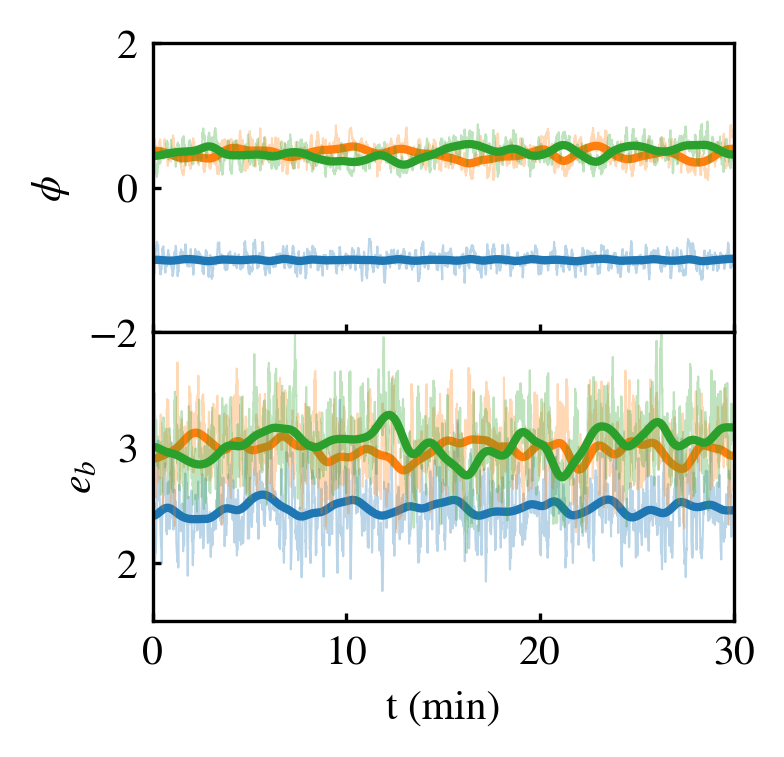

In [172]:
fig, ax = plt.subplots(2, 1, figsize=(2.5,2.5), dpi=300, sharex=True, gridspec_kw={"hspace": 0})
for num, channel in enumerate(["A", "B", "C"]):
    ax[0].plot(flowrate.t/60, flowrate[channel]/flowrate["normalizer"], label=channel, lw=.5, alpha=0.3, color=bestcolor(num))
    ax[0].plot(flowrate.t/60, gaussian_filter1d(flowrate[channel]/flowrate["normalizer"], window_size), label=channel, lw=2, alpha=1, color=bestcolor(num))
    ax[1].plot(be[channel]["frame"]/fps/60, be[channel]["bending_energy"], label=channel, lw=.5, alpha=0.3, color=bestcolor(num))
    ax[1].plot(be[channel]["frame"]/fps/60, gaussian_filter(be[channel]["bending_energy"],  window_size), label=channel, lw=2, alpha=1, color=bestcolor(num))
ax[0].set_xlim([0, 30])
ax[0].set_ylim([-2, 2])
ax[1].set_ylim([1.5, 4])
ax[1].set_yticks([2, 3])
ax[0].set_ylabel("$\phi$")
ax[1].set_ylabel("$e_b$")
ax[1].set_xlabel("t (min)")
fig.savefig("flowrate_bending.pdf")

In [78]:
# asymmetric channels
folder = r"G:\My Drive\NASync\08 jun 2023"
fps = 2
window_size = 50
be = {"A": [], "B": [], "C": []}
offset = {"A": 0, "B": 0, "C": 0}
file_range = range(11,12)
for i in file_range:
    for channel in ["A", "B", "C"]:
        e = pd.read_csv(os.path.join(folder, "bending_energy", f"{i:02d}_{channel}.csv"))[:-1]
        e["frame"] += offset[channel]
        be[channel].append(e)
        offset[channel] = e["frame"].max()
for channel in ["A", "B", "C"]:
    be[channel] = pd.concat(be[channel])
    be[channel]["bending_energy"] *= 1000

In [79]:
flowrate = []
offset = 0
for i in file_range:
    fr = pd.read_csv(os.path.join(folder, "Flow_rate", f"{i:02d}.csv")).dropna()
    fr["t"] += offset
    flowrate.append(fr)
    offset = fr["t"].max()
flowrate = pd.concat(flowrate)
flowrate["normalizer"] = gaussian_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), sigma=window_size, axis=0)

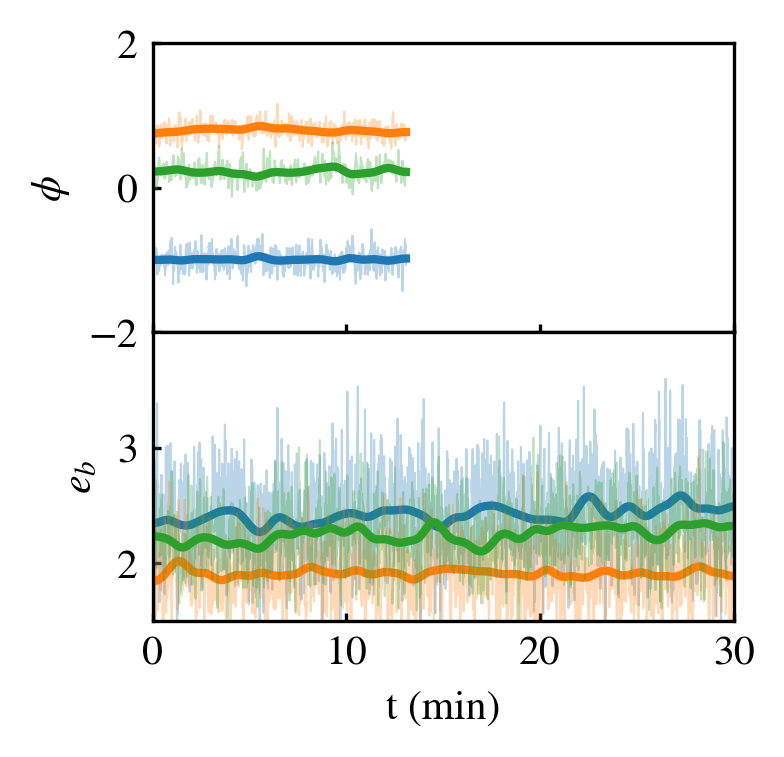

In [80]:
fig, ax = plt.subplots(2, 1, figsize=(2.5,2.5), dpi=300, sharex=True, gridspec_kw={"hspace": 0})
for num, channel in enumerate(["A", "B", "C"]):
    ax[0].plot(flowrate.t/60, flowrate[channel]/flowrate["normalizer"], label=channel, lw=.5, alpha=0.3, color=bestcolor(num))
    ax[0].plot(flowrate.t/60, gaussian_filter1d(flowrate[channel]/flowrate["normalizer"], window_size), label=channel, lw=2, alpha=1, color=bestcolor(num))
    ax[1].plot(be[channel]["frame"]/fps/60, be[channel]["bending_energy"], label=channel, lw=.5, alpha=0.3, color=bestcolor(num))
    ax[1].plot(be[channel]["frame"]/fps/60, gaussian_filter(be[channel]["bending_energy"],  window_size), label=channel, lw=2, alpha=1, color=bestcolor(num))
ax[0].set_xlim([0, 30])
ax[0].set_ylim([-2, 2])
ax[1].set_ylim([1.5, 4])
ax[1].set_yticks([2, 3])
ax[0].set_ylabel("$\phi$")
ax[1].set_ylabel("$e_b$")
ax[1].set_xlabel("t (min)")
fig.savefig("flowrate_bending")

In [87]:
flowrate.C.mean()

524.2960451233613

#### Director and energy fields

Composite the two fields on the same image background. Left: director, right: bending energy.

In [76]:
folder = r"G:\My Drive\NASync\08 jun 2023"
channel = "A"
img = io.imread(os.path.join(folder, "crop_channel", f"11_{channel}.tif"))[1200]
mask = io.imread(os.path.join(folder, "mask", f"{channel}11.tif"))

C:\Users\zl948\AppData\Local\Temp\ipykernel_26052\2746732943.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


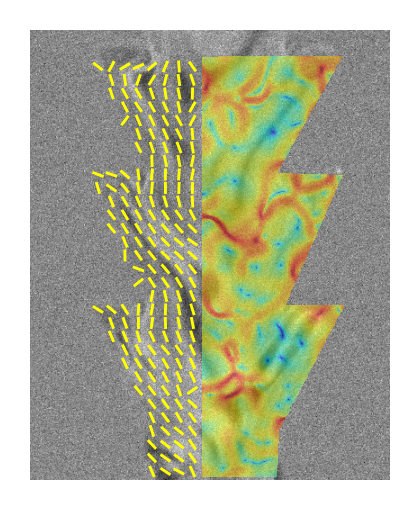

In [88]:
xlim = 190
ylim = [10, 500]
step = 15  # Adjust the step size to make the arrows sparse
Y, X = np.mgrid[ylim[0]:ylim[1]:step, 0:xlim:step]

# compute director and bending energy
d_ori = fndstruct(1, 10, img)
Q = qTensor(d_ori, 3)
be = compute_bending_energy(Q)
be[:, :xlim] = np.nan

# load and apply mask
d = d_ori.copy().astype("float")
d[~mask.astype("bool"), :] = np.nan
be[~mask.astype("bool")] = np.nan

# do figure and show image
fig = plt.figure(figsize=(1.2, 1.5), dpi=300)
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(img, cmap='gray')

# show director field on the left
ax.quiver(X, Y, d[ylim[0]:ylim[1]:step, :xlim:step, 0], d[ylim[0]:ylim[1]:step, :xlim:step, 1], color='yellow', width=.008, scale=30,  headlength=0, headwidth=0, headaxislength=0, pivot="middle")

# show bending energy on the right
ax.imshow(np.log(be), cmap="jet", alpha=0.5)

# figure controls
ax.axis("off")
plt.tight_layout()
fig.savefig(f"{channel}.pdf")

A: 0.0016660975765914572
B: 0.002905339259477719
C: 0.0018504785223349646


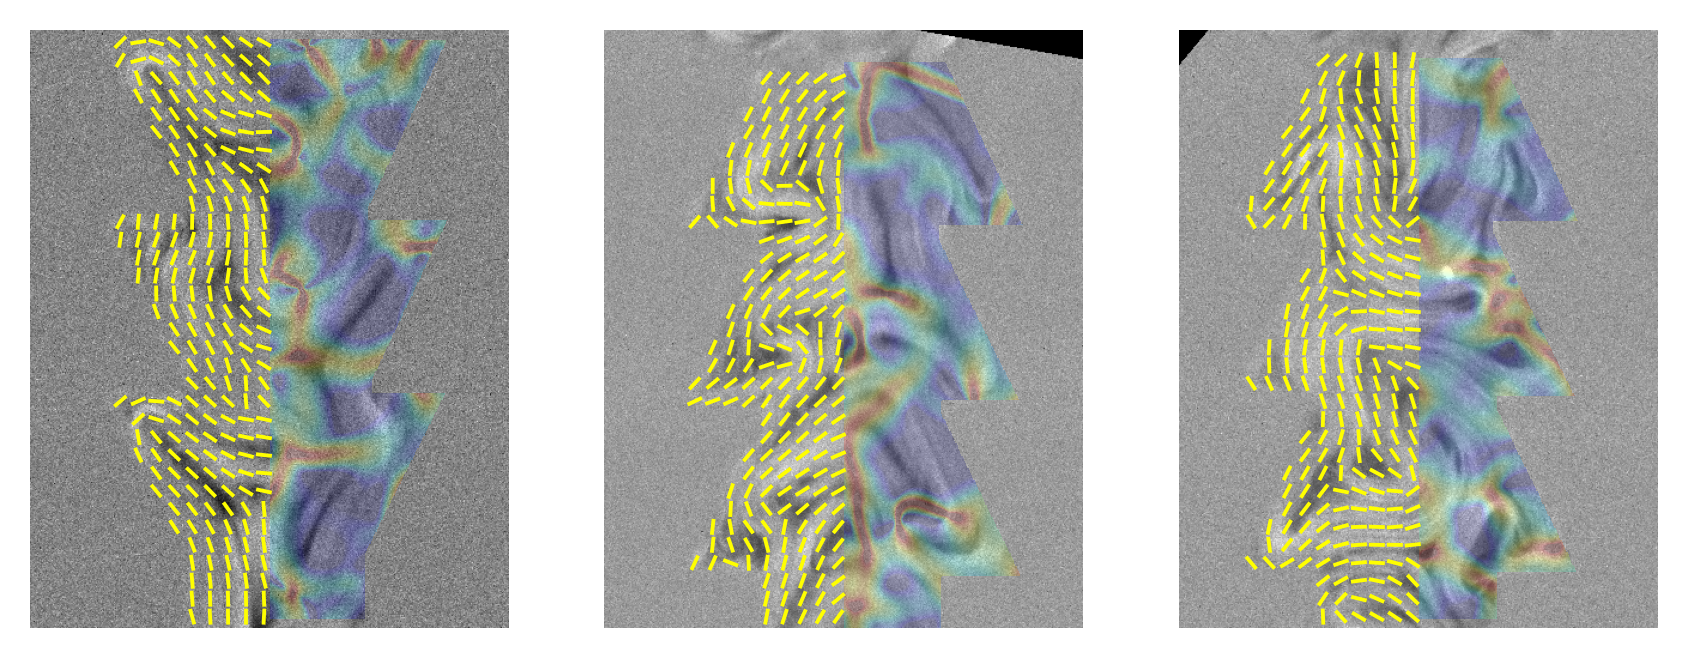

In [265]:
# screen parameters
i = 2800
xlim = 200
folder = r"G:\My Drive\NASync\08 jun 2023"
fig, ax = plt.subplots(1, 3, figsize=(7, 3), dpi=300)
bes = {"A": [], "B": [], "C": []}
for i in [3000]:
    for num, channel in enumerate(["A", "B", "C"]):
        img = io.imread(os.path.join(folder, "crop_channel", f"11_{channel}.tif"))[i]
        mask = io.imread(os.path.join(folder, "mask", f"{channel}11.tif"))
        # shrink the mask by a few pixels
        mask = cv2.erode(mask, np.ones((10, 10), np.uint8), iterations=1)

        ylim = [10, 500]
        step = 15  # Adjust the step size to make the arrows sparse
        Y, X = np.mgrid[ylim[0]:ylim[1]:step, 0:xlim:step]

        # compute director and Q-tensor bending energy
        d_ori = fndstruct(1, 15, img)
        Q = qTensor(d_ori, 1)
        be = compute_bending_energy(Q)
        
        # load and apply mask
        d = d_ori.copy().astype("float")
        d[~mask.astype("bool"), :] = np.nan
        be[~mask.astype("bool")] = np.nan
        print(f"{channel}: {np.nanmean(be)}")

        # crop bending energy
        be[:, :xlim] = np.nan

        # do figure and show image
        ax[num].imshow(img, cmap='gray')

        # show director field on the left
        ax[num].quiver(X, Y, d[ylim[0]:ylim[1]:step, :xlim:step, 0], d[ylim[0]:ylim[1]:step, :xlim:step, 1], color='yellow', width=.008, scale=30,  headlength=0, headwidth=0, headaxislength=0, pivot="middle")

        # show bending energy on the right
        ax[num].imshow(np.log(be), cmap="jet", alpha=0.2, vmin=-10, vmax=-4)

        # figure controls
        ax[num].axis("off")
        
        bes[channel].append(np.nanmean(be))
        # break

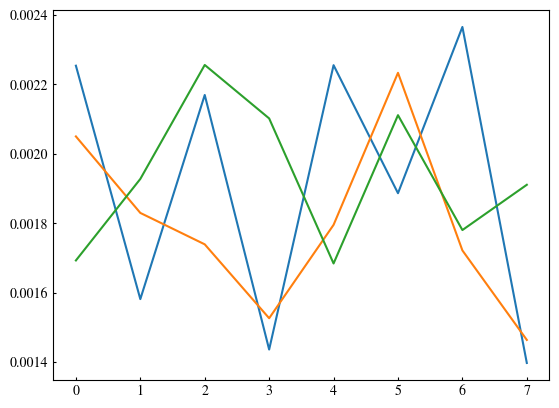

In [252]:
plt.plot(bes["A"], label="A")
plt.plot(bes["B"], label="B")
plt.plot(bes["C"], label="C")

In [139]:
shape = (100, 100)
e = np.zeros(shape)
p2_list = np.linspace(-2, 2, shape[0])
p3_list = np.linspace(-2, 2, shape[1])
for i, p2 in enumerate(p1_list):
    for j, p3 in enumerate(p2_list):
        p1 = -p2 - p3
        e[i, j] = 4*(p1 + 1)**2 + 14*(p2 - 1)**2 + 4*(p3 - 1)**2

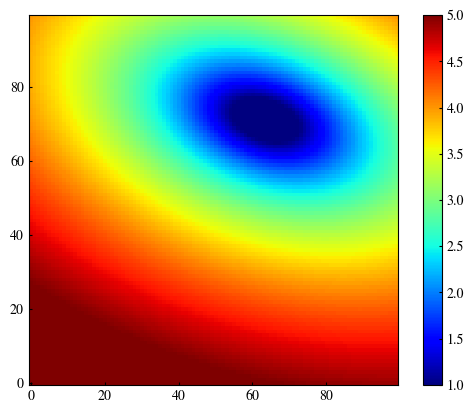

In [142]:
plt.imshow(np.log(e), vmin=1, vmax=5, origin="lower", cmap="jet")
plt.colorbar()

In [143]:
min_index = np.unravel_index(np.argmin(e), e.shape)
print(min_index)

(71, 63)


In [147]:
p1_list[71]

0.868686868686869

In [148]:
p2_list[63]

0.5454545454545459

In [150]:
p1_list[71] + p2_list[63]

1.4141414141414148